Copyright (C) 2022 Siamak Ravanbakhsh

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp451/blob/master/probabilityTheory.ipynb)

# Probability Distributions
In this notebook we create `Class`es for working with some distributions that are used often in this course.
These classes have methods for *evaluating* the pmf/pdf and for *sampling* from that distribution. 
In the next notebook we see how to estimate the parameters of these distributions using maximum likelihood principle. 

The following packages are often imported at the beginning of all notebooks. 

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt 
from IPython.core.debugger import set_trace #this is used for debugging
np.random.seed(1234) # whenver working with random numbers we can set the random seed to get the same output everytime

## 1. Bernoulli distribution
Recall the PMF of Bernoulli distribution $\mathrm{Bernoulli}(x; \mu) = \mu^{x} (1-\mu)^{1-x}$. 
To sample from $$\mathrm{Bernoulli}(x; \mu)$, we first generate a sample $z \sim U(0,1)$ from a uniform distribution, and set $x := \mathbb{I}(z < \mu>)$

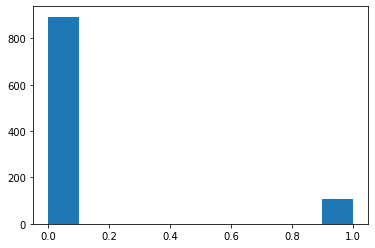

In [2]:
class Bernoulli:
    '''
    class for Bernoulli distribution
    '''
    def __init__(self, mu=.5):
        self.mu = mu

    def density(self, x):
        # assuming x is a scalar or a numpy array of zeros and ones. The probabilities will have the same shape.
        p = self.mu * x + (1-self.mu) *(1-x)
        return p

    def sample(self, n):
        # returns a vector of length n
        u = np.random.rand(n)
        x = (u < self.mu).astype(float)
        return x

samples = Bernoulli(.1).sample(1000)
plt.hist(samples)
plt.show()

## 2. Categorical distribution
This is very similar to Bernoulli, except that instead of 0's,1's we work with C categories $\{0,\ldots,C-1\}$. To best work with categorical data, we often use their **one-hot encoding**. 


In [3]:
def onehot(x, C): 
    # input x: N 
    # output: N x C
    #  assume each element of x takes values in {0,...,C-1}
    N = x.shape[0]
    x_hot = np.zeros((N,C))
    x_hot[np.arange(N), x] = 1 #use the value of x to index the last dimension
    return x_hot 

def unhot(xhot):
    #inverse of the onehot encoding
    N, C = x.shape
    x = np.nonzeros(x)[1]
    return x

N, C = 3, 4
labels = np.random.randint(0,C,N) # generate 3 random numbers between 0 and 
labels_hot = onehot(labels,C) 
print(f"labels: {labels}\none-hot encoding:\n {labels_hot}")

labels: [3 0 1]
one-hot encoding:
 [[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


For sampling can again generate from $U(0,1)$, and assign to each category based on where the sample falls. This search for the cateogiry can be done efficiently using 
binary search. Here, we use `Numpy`'s built-in functions. 

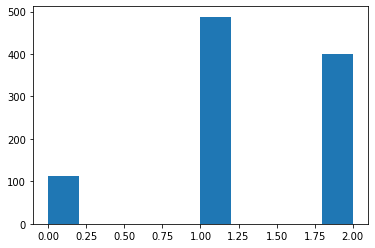

In [4]:
class Categorical:
    '''
    class for Categorical (Multinulli) distribution
    '''
    def __init__(self, mu=None):
        #mu is a vector of probabilities
        if mu is not None:
            assert(np.all(mu > 0) and np.sum(mu)==1.) #making sure mu is a probability vector
        self.mu = mu

    def density(self, x):
        # assuming x is a vector of values in {0,...C}. The probabilities will have the same shape.
        p = self.mu[x] 
        return p

    def sample(self, N):
        # returns a vector of length n
        C = self.mu.shape[0]
        x = np.random.choice(C, N,p=self.mu)
        return x

samples = Categorical(np.array([.1,.5,.4])).sample(1000)
plt.hist(samples)
plt.show()

## 3. Univariate Gaussian 
Recall the PDF of a univariate Gaussian
$$p(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left ({-\frac{1}{2}\left (\frac{x - \mu}{\sigma} \right )^2} \right )$$

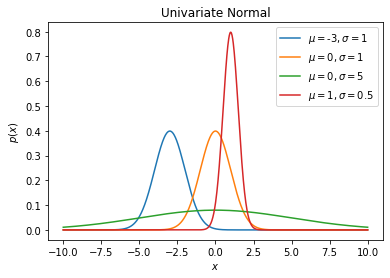

In [5]:
class Gaussian:
    '''
    class for univariate gaussian distribution
    '''
    def __init__(self, mu=0, sigma=1):
        self.mu, self.sigma = mu, sigma
        
    def density(self,x):
        return (2*np.pi*self.sigma**2)**(-.5) * np.exp(-.5* ((x - self.mu)/self.sigma)**2)
    
    def sample(self, n):
        #generate a vector of length n of samples from this pdf
        x = np.random.randn(n) * self.sigma + self.mu
        return x

gaussian = Gaussian()                                       #Instantiate the Gaussian class
x_vals = np.linspace(-10,10, 1000)                          #generate 1000 evenly placed values of x from -10 to 10
params = [(-3,1), (0, 1), (0,5), (1,.5)]                    #Different mean and std dev of gaussian we want to consider
#plot the density for differnet mean and std dev
for mu, sigma in params:
    gaussian.mu, gaussian.sigma = mu, sigma
    p_vals = gaussian.density(x_vals)
    plt.plot(x_vals, p_vals, label=r"$\mu=$"+str(mu)+r"$, \sigma=$"+str(sigma))
    
plt.xlabel(r"$x$")
plt.ylabel(r"$p(x)$")
plt.legend()
plt.title(r"Univariate Normal")
plt.show()

### 3.1 Central limit theorem
Gaussian distribution has properties that makes it special. An important property is that the average of iid random variables --under some assumptions-- has a Gaussian distribution. Various forms of this statement are known as **central limit theorems**.
Let's throw different numbers of dice and look at the distribution of their average.

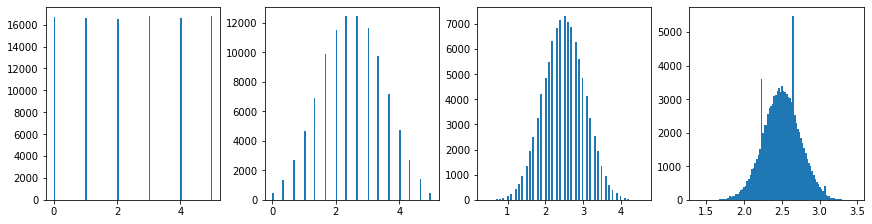

In [6]:
#number of dice to consider
#note that each dice is iid with an uniform distribution 2.5 (as the possible numbers on the faces of dice are 0,1,2,3,4,5)
num_dice = [1, 3, 10, 50]                                   
fig, axes = plt.subplots(ncols=len(num_dice), nrows=1, constrained_layout=True, figsize=(len(num_dice)*3, 3))
for i, n in enumerate(num_dice):
    trials = np.mean(np.random.randint(0,6, (n,100000)), axis = 0)           #we average the number on n dices for 100000 times and plot the distribution of the mean 
    axes[i].hist(trials, bins=100)                                           #histogram using 100 bins
    

## 4. Multivariate Gaussian
PDF of the multivariate Gaussian generalizes that of Univariate Gaussian in `D` dimensions
- think of the scalar $\sigma^2$ as a $1\times 1$ matrix. 
- the normalization term in the univariate case is $\sqrt{|2 \pi \sigma^2|}=\sqrt{2\pi\sigma^2}$.
- $\Sigma \in \!R^{D \times D}$ is the covariance matrix which replaces the variance $\sigma^2$. This gives
$\sqrt{|2 \pi \Sigma|} =  (2\pi)^{\frac{D}{2}} |\Sigma|^{\frac{1}{2}}$
    - we used the property of determinant $|c \Sigma| = c^D |\Sigma|$.
- we also need to replace $\sigma^2$ in $(\frac{x - \mu}{\sigma})^2$, but we can't divide by the matrix $\Sigma$. 
- equivalent quadratic form is $(x - \mu)^\top \Sigma^{-1} (x - \mu)$.

Putting these together we get

$$
p(x; \mu, \Sigma) = (2\pi)^{\frac{-d}{2}} |\Sigma|^{-\frac{1}{2}} \exp \left ({-\frac{1}{2}(x - \mu)^\top \Sigma^{-1} (x - \mu)} \right )
$$

Sampling from a multivariate Gaussian can be done using *Cholesky decomposition* of the covariance matrix. 
We don't cover this in the course material, but here we have the code for completeness.

In [7]:
class Gaussian():
    '''
    class for multivariate gaussian distribution
    '''
    def __init__(self, mu=0, sigma=0):
        self.mu = np.atleast_1d(mu)              #turns a scalar into 1D array otherwise preserves the arrray
        if np.array(sigma).ndim == 0:            #when sigma is scalar
            self.Sigma = np.atleast_2d(sigma**2) #turns a scalar into 2D array otherwise preserves the arrray
        else:
            self.Sigma = sigma

    def density(self, x):
        N,D = x.shape
        xm = (x-self.mu)                                                    
        normalization = ((2*np.pi)**(-D/2.)) * np.linalg.det(self.Sigma)**(-1/2.)
        quadratic = np.sum(xm @ np.linalg.inv(self.Sigma) * xm, -1)          #Note the @ sign here denotes matrix multiplication
        return normalization * np.exp(-.5 *  quadratic)
    
    def sample(self, N):
        L = np.linalg.cholesky(self.Sigma)
        D = self.mu.shape[0]
        x_std = np.random.randn(N,D)
        x = x_std @ L + self.mu
        return x
        

let's plot the density for an *bivariate*  Normal. We the overlay a set of samples generated from the same density.

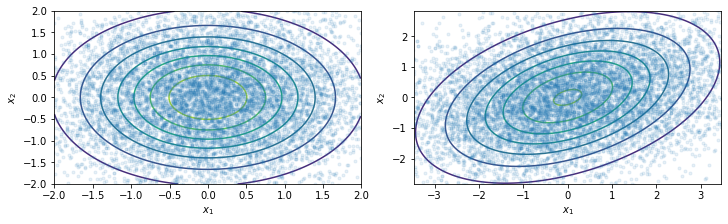

In [8]:
def plot_density(mu, Sigma, ax=None):                                 #only for 2D case
    r1 = mu[0]-2*np.sqrt(Sigma[0,0]), mu[0]+2*np.sqrt(Sigma[0,0])     #get the range of x axis in the grid
    r2 = mu[1]-2*np.sqrt(Sigma[1,1]), mu[1]+2*np.sqrt(Sigma[1,1])     #get the range of y axis in the grid
    x1, x2 = np.mgrid[r1[0]:r1[1]:.01, r2[0]:r2[1]:.01]               #get the meshgrid       
    x = np.vstack((x1.ravel(), x2.ravel())).T         #flatten it
    if not ax:
        ax = plt.gca()                                #if no axes is passed get the current Axes instance on the current figure
    p = Gaussian(mu,Sigma).density(x)                 #get the probability density values over the grid 
    #ax.set_aspect(1)
    ax.set_xlim(*r1)
    ax.set_ylim(*r2)
    ax.contour(x1, x2, p.reshape(x1.shape))           #plot the contours
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    return ax
    
#Take the parameters of two bivariate gaussian distribution
mu = np.zeros(2)
Sigma_list = np.array([[[1.,0],[0,1]],
             [[3,1.],[1.,2.]]])

fig, axes = plt.subplots(ncols=len(Sigma_list), nrows=1, constrained_layout=True, figsize=(10, 3))
for i, Sigma in enumerate(Sigma_list):
    S = np.array(Sigma)
    plot_density(mu, S, axes[i])
    x = Gaussian(mu, S).sample(10000)
    axes[i].plot(x[:,0], x[:,1], '.', alpha=.1)
plt.show()